<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_07/Part_2_07_Custom_Metrics_HuberMetric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# Step 1: Define HuberMetric
class HuberMetric(keras.metrics.Metric):
    def __init__(self, delta=1.0, name='huber_metric', **kwargs):
        super().__init__(name=name, **kwargs)
        self.delta = delta
        self.total = self.add_weight(name="total", initializer="zeros")
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        error = tf.abs(y_true - y_pred)
        is_small = error <= self.delta
        squared_loss = 0.5 * tf.square(error)
        linear_loss = self.delta * (error - 0.5 * self.delta)
        loss = tf.where(is_small, squared_loss, linear_loss)
        self.total.assign_add(tf.reduce_sum(loss))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.total / self.count

    def reset_states(self):
        self.total.assign(0.0)
        self.count.assign(0.0)

In [4]:
# Step 2: Load and Normalize Dataset
housing = fetch_california_housing()
X, y = housing.data, housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# Step 3: Build Model
model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])


In [6]:
# Step 4: Compile with HuberMetric
model.compile(optimizer='adam', loss='mse', metrics=[HuberMetric(delta=1.0)])

In [7]:
# Step 5: Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32
)

Epoch 1/25
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - huber_metric: 23.7305 - loss: 1.3633 - val_huber_metric: 24.0976 - val_loss: 0.4375
Epoch 2/25
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - huber_metric: 23.8915 - loss: 0.4605 - val_huber_metric: 23.7232 - val_loss: 0.3901
Epoch 3/25
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - huber_metric: 24.3995 - loss: 0.4042 - val_huber_metric: 24.0485 - val_loss: 0.3688
Epoch 4/25
516/516 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - huber_metric: 24.6327 - loss: 0.3587 - val_huber_metric: 23.5517 - val_loss: 0.3549
Epoch 5/25
516/516 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - huber_metric: 24.2681 - loss: 0.3661 - val_huber_metric: 23.8511 - val_loss: 0.3412
Epoch 6/25
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - huber_metric: 24.5820 - loss: 0.3279 - val_huber_metric: 24.4508 - val_loss: 0.4888
Epoch 7/25
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - huber_metric: 25.2658 - loss: 0.4141 - val_huber_metric: 24.7771 - val_loss: 0.3309
Epoch 8/25
516/516 ━━━━━━━━━━━━━━━

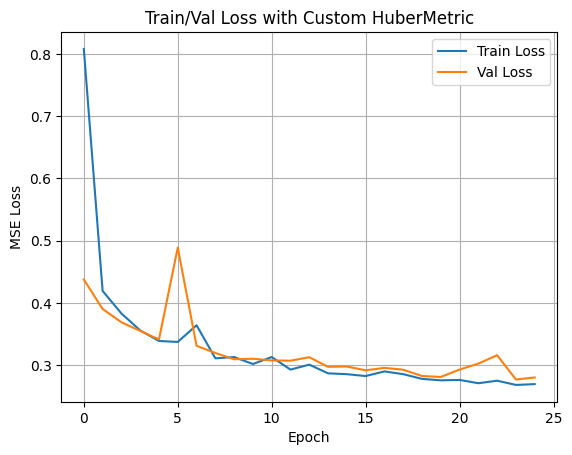

In [8]:
# Step 6: Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Train/Val Loss with Custom HuberMetric")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()